## End to end sex classification code - PyTorch

### necessary imports

In [11]:
import os
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import logging
import datetime
import nibabel as nib
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torch.utils.data import *

### Hyperparameters

In [12]:
VAL_RATIO = 0.2
TEST_RATIO = 0.2
TRAIN_RATIO = 1 - VAL_RATIO - TEST_RATIO
DATA_PARALELL = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = 'HCP'
PHASE = 'TRAIN'
K_FOLDS = 5

TASK = 'classification'
ROOT_DIR = '/data/ninad/fieldmaps/HCP_T1w'
LABEL_DIR='/data/ninad/fieldmaps/HCPCN2mm.csv'
LOG_DIR = '/home/neelamlab/ninad/DWI/logs'
timestamp = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
RESULT_DIR = f'/home/neelamlab/ninad/DWI/results/run_{timestamp}'
os.makedirs(RESULT_DIR,exist_ok=True)
TEST_BATCH_SIZE = 2

BATCH_SIZE=16
LEARNING_RATE=0.0001
NUM_EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

NP_SEED = 42
TORCH_SEED = 36

### Setting the seed

In [13]:
np.random.seed(NP_SEED)
torch.manual_seed(TORCH_SEED)

### Setting up logger

In [14]:
def setup_logger(logs_dir=LOG_DIR,dataset=None,phase=None):
    os.makedirs(logs_dir, exist_ok=True)
    logger = logging.getLogger('RunLogger')
    logger.setLevel(logging.INFO)

    if not logger.hasHandlers():
        timestamp = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
        file_handler = logging.FileHandler(os.path.join(logs_dir, f'{phase}_{dataset}_{timestamp}.log'))
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)
    
    return logger

LOGGER = setup_logger(logs_dir=LOG_DIR,phase=PHASE,dataset=DATASET)

### Dataset Class

In [15]:
class Fieldmapdata(Dataset):
    """
    Dataset class for loading neuroimaging data and associated labels for classification or regression tasks.

    Attributes:
        root_dir (str): Path to the directory containing image data files (.nii or .nii.gz).
        label_dir (str): Path to the CSV file containing labels for each subject.
        task (str): Specifies the task type: classification (Gender) or regression (Age).
    """
    def __init__(self, root_dir, label_dir, task='classification'):
        self.labels_df = self.load_labels(label_dir) #load the labels
        self.samples = self.make_dataset(root_dir, task=task) #assign the labels to each file in the root_dir

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        nifti_data = nib.load(img_path)
        data = nifti_data.get_fdata()
        image_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0) #unsqueeze to add channel dimension
        label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        return image_tensor, label_tensor
       
    def make_dataset(self, root_dir, task = None):
        samples = []
        labels_df = self.labels_df
        for root, _, fnames in os.walk(root_dir):
            for fname in fnames:
                if fname.endswith(".nii.gz") or fname.endswith(".nii"):
                    path = os.path.join(root, fname)
                    id_ = self.extract_id_from_filename(fname)
                    try:
                        if task == 'regression': 
                            label = labels_df[labels_df['Subject'] == id_]['Age'].iloc[0] 
                        if task == 'classification': 
                            label = labels_df[labels_df['Subject'] == id_]['Gender'].iloc[0]
                        samples.append((path, label))
                    except:
                        continue
        return samples
    
    def extract_id_from_filename(self, fname):
        '''match the filename to key to query in the labels dictionary'''
        fname = fname.replace("sub-","")
        if fname.endswith("_ad.nii.gz"):
            id_ = fname.replace("_ad.nii.gz", "")
        elif fname.endswith("_rd.nii.gz"):
            id_ = fname.replace("_rd.nii.gz", "")
        elif fname.endswith("_adc.nii.gz"):
            id_ = fname.replace("_adc.nii.gz", "")
        elif fname.endswith("_fa.nii.gz"):
            id_ = fname.replace("_fa.nii.gz", "")
        elif fname.endswith(".nii.gz"):
            id_ = fname.replace(".nii.gz", "")
        return id_

    def load_labels(self, label_path):
        '''tip: use astype(required datatype)'''
        df = pd.read_csv(label_path)
        df_filtered = df[['Subject', 'Gender', 'Age']].copy()
        df_filtered['Gender'] = df_filtered['Gender'].map({'M': 0, 'F': 1}).astype(int)
        df_filtered['Age'] = df_filtered['Age'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) // 2 if '-' in x else int(x[:-1])).astype(float)
        # In HCP-Y age is a bin of 4 years, here i can assigning the average value of the bin range to each subject
        df_filtered['Subject'] = df_filtered['Subject'].astype(str)
        return df_filtered

### Create the dataset and split into training and testing

In [17]:
dataset = Fieldmapdata(root_dir=ROOT_DIR,label_dir=LABEL_DIR,task=TASK)
train_dataset, val_dataset, test_dataset = random_split(dataset, [TRAIN_RATIO, VAL_RATIO, TEST_RATIO])

### Dataloder

In [18]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

### Comparing the shape of image at each stage

In [19]:
RANDOM_IMAGE_PATH = '/data/ninad/fieldmaps/HCP_T1w/sub-100610.nii.gz'
raw_image = nib.load(RANDOM_IMAGE_PATH).get_fdata()
train_image = train_dataset.__getitem__(1)[0]
train_batch = next(iter(train_dl))

print('Raw image shape',raw_image.shape,'\n' 'Train image shape', train_image.shape,'\n' 'Batch shape',train_batch[0].shape)

Raw image shape (91, 109, 91) 
Train image shape torch.Size([1, 91, 109, 91]) 
Batch shape torch.Size([16, 1, 91, 109, 91])


### Stratify the labels for classification

In [20]:
def stratified_split_classification(dataset, test_size):
    labels = [dataset[i][-1] for i in range(len(dataset))]  # Assuming label is the last element
    # cannot access sample variable for all instances, will thorw AttributeError: 'Subset' object has no attribute 'samples'
    train_indices, test_indices = train_test_split(
        range(dataset.__len__()), test_size=test_size, stratify=labels
    )
    train_ds = Subset(dataset, train_indices)
    test_ds = Subset(dataset, test_indices)
    return train_ds, test_ds

def splitting_data(dataset, TEST_RATIO: float, stratify: bool=False):
    if stratify:
        train_ds, test_ds = stratified_split_classification(dataset, TEST_RATIO)
    else:
        train_ds, test_ds = random_split(dataset, [1-TEST_RATIO, TEST_RATIO])
    return train_ds, test_ds

In [21]:
train_and_val_ds, test_ds = stratified_split_classification(dataset, test_size=TEST_RATIO)
train_ds, val_ds = stratified_split_classification(train_and_val_ds, test_size=VAL_RATIO)
LOGGER.info('Data split completed !!')

### verifying

In [22]:
dataset_labels = []
for ds in [train_ds, val_ds, test_ds]:
    labels = []
    for i, j in ds:
        labels.append(j)
    dataset_labels.append(labels)
    
for num, phase in enumerate(['Train', 'Val', 'Test']):
    Total_subjects = len(dataset_labels[num]), 
    males_count = len(dataset_labels[num]) - sum(dataset_labels[num])
    females_count = sum(dataset_labels[num]), 
    ratio = (len(dataset_labels[num]) - sum(dataset_labels[num])) / sum(dataset_labels[num])
    print(f'Phase {phase}, total: {Total_subjects[0]}, ratio: {ratio}')

Phase Train, total: 542, ratio: tensor([0.8007])
Phase Val, total: 136, ratio: tensor([0.7895])
Phase Test, total: 170, ratio: tensor([0.7895])


In [23]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

### My dataloder function

In [13]:
def prepare_dataloader(dataset: Dataset, batch_size: int, num_workers: int = 4):
    return DataLoader(
        dataset,
        batch_size=batch_size, # hyperparameter, 8 is good, (lower batch size fine grain details)
        pin_memory=True, # proved to be faster while using DDP
        shuffle=False, #shuffle is mutually exclusive with distributed sampler
        num_workers=num_workers, # 4, CPUs used to deliver the data to GPU, higher value --> better GPU utilisation, does not guarrentee faster epoch
        sampler=DistributedSampler(dataset) #required for DDP
    )

### model

In [24]:
'''copied from https://github.com/ha-ha-ha-han/UKBiobank_deep_pretrain/blob/master/dp_model/model_files/sfcn.py'''
'''This code is hardcoded for a specific input shape: ie. [batch_size, 1, 160, 192, 160]'''

class SFCN(nn.Module):
    def __init__(self, channel_number=[32, 64, 128, 256, 256, 64], output_dim=1, dropout=True): #default output_dim changed from 40 to 1
        super(SFCN, self).__init__()
        n_layer = len(channel_number)
        self.feature_extractor = nn.Sequential()
        for i in range(n_layer):
            if i == 0:
                in_channel = 1
            else:
                in_channel = channel_number[i-1]
            out_channel = channel_number[i]
            if i < n_layer-1:
                self.feature_extractor.add_module('conv_%d' % i,
                                                  self.conv_layer(in_channel,
                                                                  out_channel,
                                                                  maxpool=True,
                                                                  kernel_size=3,
                                                                  padding=1))
            else:
                self.feature_extractor.add_module('conv_%d' % i,
                                                  self.conv_layer(in_channel,
                                                                  out_channel,
                                                                  maxpool=False,
                                                                  kernel_size=1,
                                                                  padding=0))
        self.classifier = nn.Sequential()
        ############################## Hard coded ####################################### 
        #avg_shape = [5, 6, 5] 
        #self.classifier.add_module('average_pool', nn.AvgPool3d(avg_shape))
        ############################## Hard coded ####################################### 

        ############################## Change ####################################### 
        self.classifier.add_module('average_pool', nn.AdaptiveAvgPool3d(1))
        ############################## Change ####################################### 

        if dropout is True:
            self.classifier.add_module('dropout', nn.Dropout(0.5))
        i = n_layer
        in_channel = channel_number[-1]
        out_channel = output_dim
        self.classifier.add_module('conv_%d' % i,
                                   nn.Conv3d(in_channel, out_channel, padding=0, kernel_size=1))

    @staticmethod
    def conv_layer(in_channel, out_channel, maxpool=True, kernel_size=3, padding=0, maxpool_stride=2):
        if maxpool is True:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.MaxPool3d(2, stride=maxpool_stride),
                nn.ReLU(),
            )
        else:
            layer = nn.Sequential(
                nn.Conv3d(in_channel, out_channel, padding=padding, kernel_size=kernel_size),
                nn.BatchNorm3d(out_channel),
                nn.ReLU()
            )
        return layer

    def forward_original (self, x):
        out = list()
        x_f = self.feature_extractor(x)
        x = self.classifier(x_f)
        x = F.log_softmax(x, dim=1)
        out.append(x)
        return out
    
    def forward(self, x):
        '''Instead of list output datatype i prefer tensor and as we are performing Binary classification / Regression, we will not apply softmax'''
        # print('In shape', x.shape)
        x_f = self.feature_extractor(x)
        # print('After feature extraction module shape', x_f.shape)
        x = self.classifier(x_f)
        # print('After classification module shape', x.shape)
        x = x.view(x.size(0), -1) #flattening
        # print('After Flattening shape', x.shape)
        return x

In [25]:
from torchinfo import summary
model = SFCN()
summary(model=model, input_size=(16,1,91,109,91))

Layer (type:depth-idx)                   Output Shape              Param #
SFCN                                     [16, 1]                   --
├─Sequential: 1-1                        [16, 64, 2, 3, 2]         --
│    └─Sequential: 2-1                   [16, 32, 45, 54, 45]      --
│    │    └─Conv3d: 3-1                  [16, 32, 91, 109, 91]     896
│    │    └─BatchNorm3d: 3-2             [16, 32, 91, 109, 91]     64
│    │    └─MaxPool3d: 3-3               [16, 32, 45, 54, 45]      --
│    │    └─ReLU: 3-4                    [16, 32, 45, 54, 45]      --
│    └─Sequential: 2-2                   [16, 64, 22, 27, 22]      --
│    │    └─Conv3d: 3-5                  [16, 64, 45, 54, 45]      55,360
│    │    └─BatchNorm3d: 3-6             [16, 64, 45, 54, 45]      128
│    │    └─MaxPool3d: 3-7               [16, 64, 22, 27, 22]      --
│    │    └─ReLU: 3-8                    [16, 64, 22, 27, 22]      --
│    └─Sequential: 2-3                   [16, 128, 11, 13, 11]     --
│    │   

### Model, Optimiser, Loss etc

In [26]:
model = SFCN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss() 
# criterion2 = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1.28,dtype=torch.float32)) # Total subjects: 899 Number of males : 395, number of females: 504, pos_weight = 1.2759493670886075
# Females are class 1, ratio of class to class 0 --> 504/395 = 1.27
# if using cross entropy loss / BCEloss instead of BCEwothlogits loss remember to use sigmoid / softmax

### simpler train/val loop

In [27]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    for inputs, labels in train_dl:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        tloss = criterion(outputs, labels)
        tloss.backward()
        optimizer.step()
        train_loss += tloss.item() / inputs.size(0)
        probability = torch.sigmoid(outputs) # during inference you have to apply sigmoid
        predicted = (probability >= 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_dl:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(inputs)
            vloss = criterion(outputs, labels)
            val_loss += vloss.item() / inputs.size(0)
            probability = torch.sigmoid(outputs)
            predicted = (probability >= 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.4f} Train Accu: {train_accuracy:.2f}% Val Loss: {val_loss:.4f} Val Accu: {val_accuracy:.2f}%")
        LOGGER.info(f"Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.4f} Train Accu: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Accu: {val_accuracy:.4f}")
torch.save(model.state_dict(),'best_model.pt')

Epoch [1/10]: Train Loss: 1.2264 Train Accu: 66.01% Val Loss: 1.3759 Val Accu: 56.47%
Epoch [2/10]: Train Loss: 0.9750 Train Accu: 80.94% Val Loss: 2.1438 Val Accu: 56.47%
Epoch [3/10]: Train Loss: 0.7570 Train Accu: 89.78% Val Loss: 1.6919 Val Accu: 56.47%
Epoch [4/10]: Train Loss: 0.6767 Train Accu: 92.73% Val Loss: 0.4865 Val Accu: 57.06%
Epoch [5/10]: Train Loss: 0.5644 Train Accu: 95.48% Val Loss: 1.0497 Val Accu: 56.47%
Epoch [6/10]: Train Loss: 0.4637 Train Accu: 98.82% Val Loss: 0.8312 Val Accu: 57.06%
Epoch [7/10]: Train Loss: 0.3794 Train Accu: 99.61% Val Loss: 0.6105 Val Accu: 45.88%
Epoch [8/10]: Train Loss: 0.3283 Train Accu: 100.00% Val Loss: 0.5350 Val Accu: 60.00%
Epoch [9/10]: Train Loss: 0.2846 Train Accu: 100.00% Val Loss: 0.4364 Val Accu: 61.18%
Epoch [10/10]: Train Loss: 0.2597 Train Accu: 100.00% Val Loss: 0.8957 Val Accu: 57.06%


In [18]:
best_model = SFCN()
# best_model.load_state_dict('best_model.pt')

#using the above model for now
new_state_dict = {}
for key, value in model.state_dict().items():
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value
best_model.load_state_dict(new_state_dict)

<All keys matched successfully>

TEST LOSS: 42.06333679519594, TEST ACCURACY: 55.62130177514793
Accuracy: 0.5562130177514792, Sensitivity (Recall): 1.0
CM:  [[ 1 75]
 [ 0 93]]


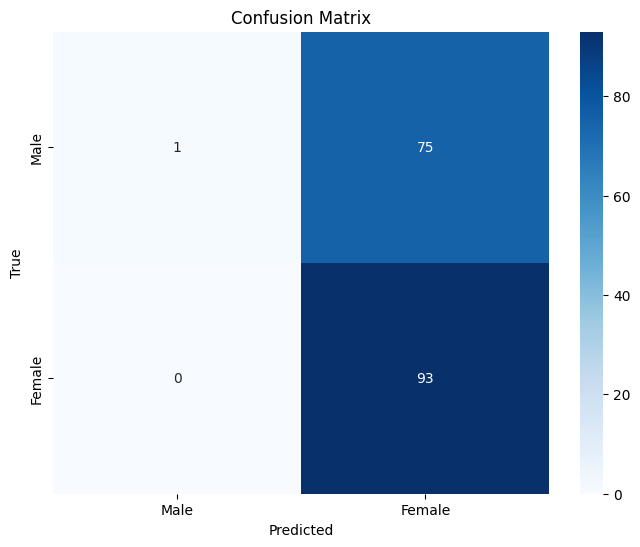

In [19]:
best_model.to(DEVICE)
best_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0

with torch.no_grad():
    all_predicted = []
    all_labels = []
    for inputs, labels in test_dl:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = best_model(inputs)
        te_loss = criterion(outputs, labels)
        test_loss += te_loss.item()/inputs.size(0)
        probability = torch.sigmoid(outputs)
        predicted = (probability >= 0.5).float()
        all_predicted.extend(predicted.cpu().numpy().ravel().tolist())
        all_labels.extend(labels.cpu().numpy().ravel().tolist())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total

print(f"TEST LOSS: {test_loss}, TEST ACCURACY: {test_accuracy}")
LOGGER.info(f"TEST LOSS: {test_loss}, TEST ACCURACY: {test_accuracy}")
accuracy = accuracy_score(all_labels, all_predicted)
sensitivity = recall_score(all_labels, all_predicted)
print(f'Accuracy: {accuracy}, Sensitivity (Recall): {sensitivity}')
LOGGER.info(f'Accuracy: {accuracy}, Sensitivity (Recall): {sensitivity}')

cm = confusion_matrix(all_labels, all_predicted)
print('CM: ',cm)
LOGGER.info(f"CM : {cm}")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('cm.png')

### K-Fold Cross Validation for Training with early stopping

In [20]:
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=NP_SEED)
fold_train_losses, fold_val_losses = [], []
fold_train_accuracies, fold_val_accuracies = [], []
LOGGER.info(f"{K_FOLDS} FOLDS CROSS VALIATION TARINING STARTED")

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f'Fold {fold+1}/{K_FOLDS}')
    LOGGER.info(f'Fold {fold+1}/{K_FOLDS}')
    
    train_ds = Subset(train_dataset, train_idx)
    val_ds = Subset(train_dataset, val_idx)
    
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = SFCN().to(DEVICE)
    model = nn.DataParallel(model) 
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = np.inf
    epochs_without_improvement = 0

    # Train the model for each fold
    for epoch in range(NUM_EPOCHS):
        model.train()
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        for inputs, labels in train_dl:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            tloss = criterion(outputs, labels)
            tloss.backward()
            optimizer.step()
            train_loss += tloss.item() / inputs.size(0)
            probability = torch.sigmoid(outputs)
            predicted = (probability >= 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = 100 * train_correct / train_total
        fold_train_accuracies.append(train_accuracy)
        fold_train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(inputs)
                vloss = criterion(outputs, labels)
                val_loss += vloss.item() / inputs.size(0)
                probability = torch.sigmoid(outputs)
                predicted = (probability >= 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

            val_accuracy = 100 * val_correct / val_total
            fold_val_accuracies.append(val_accuracy)
            fold_val_losses.append(val_loss)

            print(f"Fold [{fold+1}/{K_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.4f} Train Accu: {train_accuracy:.2f}% Val Loss: {val_loss:.4f} Val Accu: {val_accuracy:.2f}%")
            LOGGER.info(f"Fold [{fold+1}/{K_FOLDS}], Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.4f} Train Accu: {train_accuracy:.2f}% Val Loss: {val_loss:.4f} Val Accu: {val_accuracy:.2f}%")
        
        # Early stopping
        if epoch > 30:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0 

                new_state_dict = {}
                for key, value in model.state_dict().items():
                    new_key = key.replace("module.", "")
                    new_state_dict[new_key] = value
                best_model.load_state_dict(new_state_dict)

                # torch.save(model.state_dict(), f'{RESULT_DIR}/model_{fold+1}_epoch{epoch}.pt') # will create a lot of model and take a lot of space
                LOGGER.info(f"Validation loss improved for fold {fold+1} at epoch {epoch+1}")
            else:
                epochs_without_improvement += 1
                LOGGER.info(f"No improvement in validation loss for {epochs_without_improvement} epochs for fold {fold+1}")

            if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
                print(f"Early stopping triggered for fold {fold+1} at epoch {epoch+1}")
                LOGGER.info(f"Early stopping triggered for fold {fold+1} at epoch {epoch+1}")
                ## save best model before stopping
                torch.save(model.state_dict(), f'{RESULT_DIR}/best_model_{fold+1}_epoch{epoch}.pt')
                break
    
    torch.save(model.state_dict(), f'{RESULT_DIR}/best_model_{fold+1}_epoch{epoch}.pt') ## save model as best model if the training ends for a fold

# Aggregate the results across all folds
avg_train_loss = np.mean(fold_train_losses)
avg_val_loss = np.mean(fold_val_losses)
avg_train_accuracy = np.mean(fold_train_accuracies)
avg_val_accuracy = np.mean(fold_val_accuracies)

print(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accu: {avg_train_accuracy:.2f}%, Avg Val Loss: {avg_val_loss:.4f}, Avg Val Accu: {avg_val_accuracy:.2f}%")
LOGGER.info(f"Avg Train Loss: {avg_train_loss:.4f}, Avg Train Accu: {avg_train_accuracy:.2f}%, Avg Val Loss: {avg_val_loss:.4f}, Avg Val Accu: {avg_val_accuracy:.2f}%")

Fold 1/5


Fold [1/5], Epoch [1/10]: Train Loss: 1.1027 Train Accu: 65.11% Val Loss: 1.1186 Val Accu: 50.98%
Fold [1/5], Epoch [2/10]: Train Loss: 1.0359 Train Accu: 69.29% Val Loss: 1.2397 Val Accu: 50.98%
Fold [1/5], Epoch [3/10]: Train Loss: 0.9748 Train Accu: 69.04% Val Loss: 0.2247 Val Accu: 82.35%
Fold [1/5], Epoch [4/10]: Train Loss: 0.9140 Train Accu: 76.90% Val Loss: 0.8988 Val Accu: 50.98%
Fold [1/5], Epoch [5/10]: Train Loss: 0.8699 Train Accu: 76.41% Val Loss: 0.6120 Val Accu: 50.98%
Fold [1/5], Epoch [6/10]: Train Loss: 0.7704 Train Accu: 83.05% Val Loss: 1.0548 Val Accu: 50.98%
Fold [1/5], Epoch [7/10]: Train Loss: 0.8332 Train Accu: 77.89% Val Loss: 0.2202 Val Accu: 77.45%
Fold [1/5], Epoch [8/10]: Train Loss: 0.7286 Train Accu: 84.77% Val Loss: 0.2578 Val Accu: 71.57%
Fold [1/5], Epoch [9/10]: Train Loss: 0.7944 Train Accu: 80.84% Val Loss: 1.3172 Val Accu: 49.02%
Fold [1/5], Epoch [10/10]: Train Loss: 0.7981 Train Accu: 79.85% Val Loss: 1.7724 Val Accu: 50.98%
Fold 2/5
Fold [2/5]

KeyboardInterrupt: 

Testing remains the same

TEST LOSS: 14.311684928834438, TEST ACCURACY: 89.94082840236686
Accuracy: 0.8994082840236687, Sensitivity (Recall): 0.9354838709677419
CM:  [[65 11]
 [ 6 87]]


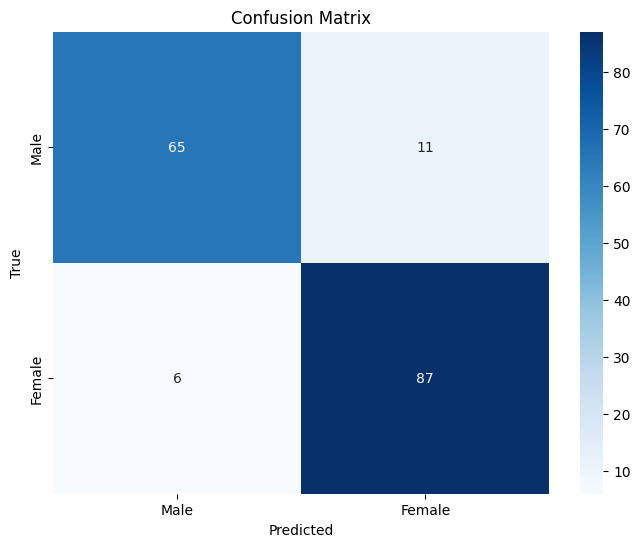

In [24]:
best_model = SFCN()

best_model_state_dict = torch.load('/home/neelamlab/ninad/DWI/results/run_07_11_2024_16_27_35/best_model_2_epoch9.pt', weights_only=True)
new_state_dict = {}
for key, value in best_model_state_dict.items():
    new_key = key.replace("module.", "")
    new_state_dict[new_key] = value
best_model.load_state_dict(new_state_dict)

best_model.to(DEVICE)
best_model.eval()
test_loss = 0.0
test_total = 0
test_correct = 0

with torch.no_grad():
    all_predicted = []
    all_labels = []
    for inputs, labels in test_dl:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        outputs = best_model(inputs)
        te_loss = criterion(outputs, labels)
        test_loss += te_loss.item()/inputs.size(0)
        probability = torch.sigmoid(outputs)
        predicted = (probability >= 0.5).float()
        all_predicted.extend(predicted.cpu().numpy().ravel().tolist())
        all_labels.extend(labels.cpu().numpy().ravel().tolist())
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total

print(f"TEST LOSS: {test_loss}, TEST ACCURACY: {test_accuracy}")
LOGGER.info(f"TEST LOSS: {test_loss}, TEST ACCURACY: {test_accuracy}")
accuracy = accuracy_score(all_labels, all_predicted)
sensitivity = recall_score(all_labels, all_predicted)
print(f'Accuracy: {accuracy}, Sensitivity (Recall): {sensitivity}')
LOGGER.info(f'Accuracy: {accuracy}, Sensitivity (Recall): {sensitivity}')

cm = confusion_matrix(all_labels, all_predicted)
print('CM: ',cm)
LOGGER.info(f"CM : {cm}")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('cm.png')